## GI Behavior Health

In [ ]:
(1+0.2)**10

6.191736422399997

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
file_path = '/content/drive/My Drive/GI_Behavior_Health/Data/Code Frequency.xlsx'
code_distn = pd.read_excel(file_path)
df = code_distn

df.rename(columns = {'Sum of Procedure Count': 'Count'}, inplace = True)
df
#code_distn


,CPT Code,CPT Description,Time,Count
0,90853,group,60.0,788
1,90837,individual,60.0,230
2,90791,individual,60.0,158
3,90834,individual,60.0,156
4,90832,individual,30.0,116
5,96159,individual,15.0,46
6,96156,individual,30.0,42
7,90028,individual,15.0,16
8,96158,individual,30.0,14
9,90021,individual,15.0,10


In [12]:
df['Count'].dtype

dtype('int64')

In [14]:
# --------------------
# For individual appointments, calculate the ratio of 60-min, 45-min, and 30-min appointments
# --------------------

def ratio_calculator(df):
  df_60 = df[(df['Time'] == 60.0) & (df['CPT Description'] == 'individual')]
  df_45 = df[(df['Time'] == 15.0) & (df['CPT Description'] == 'individual')]
  df_30 = df[(df['Time'] == 30.0) & (df['CPT Description'] == 'individual')]
  print(df_60)
  print(df_45)
  print(df_30)
  indivi_60 = df_60['Count'].sum()
  indivi_45 = df_45['Count'].sum()
  indivi_30 = df_30['Count'].sum()
  total_appts = indivi_60 + indivi_45 + indivi_30
  ratio_60 = indivi_60 / total_appts
  ratio_45 = indivi_45 / total_appts
  ratio_30 = indivi_30 / total_appts

  return ratio_60, ratio_45, ratio_30

ratio_60, ratio_45, ratio_30 = ratio_calculator(df)
print(ratio_60, ratio_45, ratio_30)


  CPT Code CPT Description  Time  Count
1    90837      individual  60.0    230
2    90791      individual  60.0    158
3    90834      individual  60.0    156
   CPT Code CPT Description  Time  Count
5     96159      individual  15.0     46
7     90028      individual  15.0     16
9     90021      individual  15.0     10
10    90785      individual  15.0      8
  CPT Code CPT Description  Time  Count
4    90832      individual  30.0    116
6    96156      individual  30.0     42
8    96158      individual  30.0     14
0.6834170854271356 0.10050251256281408 0.21608040201005024


In [ ]:
df = code_distn.sort_values(by = 'Count', ascending = True)
df

,CPT Code,Count
12,99212 – ignore this,2
11,97802 – ignore this,4
10,"90785 (added complexity code, not time based)",8
9,"90021 (not time based, not financial)",10
8,"96158 (intervention visit, 30 minutes)",14
7,90028 (no charge visit),16
6,96156 (new patient visit – not time based),42
5,"96159 (intervention visit, 15 minutes)",46
4,90832 (30 minute follow up visit),116
3,90834 (45 minute follow up visit – takes a 60 ...,156


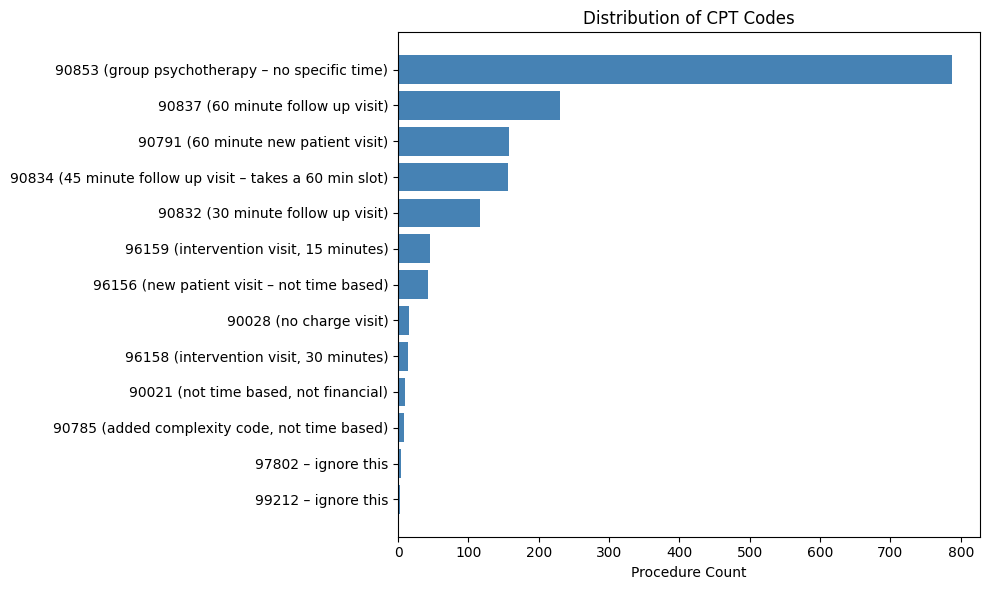

In [ ]:
# Plot
df_draw = df.iloc[:-1,:]
plt.figure(figsize=(10, 6))
plt.barh(df_draw['CPT Code'], df_draw['Count'], color='steelblue')
plt.xlabel('Procedure Count')
plt.title('Distribution of CPT Codes')
plt.tight_layout()
plt.show()

## Aggregate providers' individual and group treatment


In [ ]:
import pandas as pd

# 1. Load your data
appts_wide = pd.read_excel(
    '/content/drive/My Drive/GI_Behavior_Health/Parameters/BH Data CPT Code Retrieval.xlsx'
)
cpt = pd.read_excel(
    '/content/drive/My Drive/GI_Behavior_Health/Parameters/Code Frequency.xlsx'
)

# 2. Unpivot the months into a long table
id_cols    = ['Service Provider', 'CPT Code']
month_cols = [c for c in appts_wide.columns if c not in id_cols]

appts = appts_wide.melt(
    id_vars    = id_cols,
    value_vars = month_cols,
    var_name   = 'Month',
    value_name = 'Count'
)

# 3. Extract the year
appts['Year'] = pd.to_datetime(appts['Month']).dt.year

# 4. Merge in time per code and description
#    (assumes cpt_lookup has columns 'CPT Code', 'CPT Description', and 'Time')
df = (
    appts
    .merge(cpt[['CPT Code','CPT Description','Time']],
           on='CPT Code', how='left')
)

# 5. Label each row as Individual or Group
df['Type'] = df['CPT Description'] \
    .str.contains('group', case=False, na=False) \
    .map({True: 'Group', False: 'Individual'})

# 6. Compute total minutes spent on each row
df['TotalTimeMin'] = df['Count'] * df['Time']

# 7. Aggregate by provider, year, and type
summary = (
    df
    .groupby(['Service Provider','Year','Type'])['TotalTimeMin']
    .sum()
    .unstack(fill_value=0)      # columns become ['Group','Individual'] if both exist
    .reset_index()
)

# 8. Clean up names and convert to hours
summary = summary.rename(columns={
    'Service Provider': 'Provider',
    'Individual':       'IndividualMin',
    'Group':            'GroupMin'
})
# If one of the columns was missing, ensure it's present
for col in ['IndividualMin','GroupMin']:
    if col not in summary.columns:
        summary[col] = 0

summary['IndividualHours'] = summary['IndividualMin'] / 60
summary['GroupHours']      = summary['GroupMin']      / 60

# 9. Final table
print(summary[[
    'Provider','Year',
    'IndividualMin','GroupMin',
    'IndividualHours','GroupHours'
]])

Type                   Provider  Year  IndividualMin  GroupMin  \
0              DUARTE, BROOKE A  2022            0.0       0.0   
1              DUARTE, BROOKE A  2023        13290.0    1080.0   
2              DUARTE, BROOKE A  2024        21030.0   10440.0   
3              DUARTE, BROOKE A  2025         7440.0    5880.0   
4             HACKER, KATRINA S  2022         7185.0    1260.0   
5             HACKER, KATRINA S  2023        28590.0   20700.0   
6             HACKER, KATRINA S  2024        28005.0   15960.0   
7             HACKER, KATRINA S  2025         8505.0    3780.0   
8               LEE, SAMANTHA K  2022            0.0       0.0   
9               LEE, SAMANTHA K  2023         6360.0    3660.0   
10              LEE, SAMANTHA K  2024        12270.0    8880.0   
11              LEE, SAMANTHA K  2025            0.0       0.0   
12    SALWEN-DEREMER, JESSICA K  2022        18360.0   34560.0   
13    SALWEN-DEREMER, JESSICA K  2023        16560.0   18840.0   
14    SALW

In [ ]:
## Calculate the individual fill rate
from datetime import datetime, timedelta

def count_weekdays(start_str, end_str, fmt="%m/%d/%Y"):
    """
    Count weekdays (Mon–Fri) inclusive between two dates.
    """
    start = datetime.strptime(start_str, fmt)
    end   = datetime.strptime(end_str,   fmt)

    # Ensure start ≤ end
    if end < start:
        start, end = end, start

    total = 0
    current = start
    while current <= end:
        if current.weekday() < 5:       # Monday=0, Sunday=6
            total += 1
        current += timedelta(days=1)
    return total


fill_rate = {'Brooke':[0,0,0,0],
             'Katrina':[0,0,0,0],
             'Samantha':[0,0,0,0],
             'Jessica':[0,0,0,0]}

# Brooke: 2022: N/A, 2023: Aug-Dec: 8h, 2024: Jan-June: 8h, Sep-Dec: 16h
fill_rate['Brooke'][1] = (221.50+18)/(count_weekdays("08/01/2023", "12/31/2023") * 1.6)
fill_rate['Brooke'][2] = (350.5+174)/(count_weekdays("01/01/2023", "06/30/2023")* 1.6 + count_weekdays("09/01/2023", "12/31/2023") * 3.2)

# Katrina: 2022: Oct-Dec: 16h, 2023: Jan-Aug: 16h, Oct: 22h, Nov-Dec: 40h, 2024: Jan-March: 40h, Apr: 25.6, May-Jun:40h, July-Aug: 29.2, Sep: 32.8, Oct-Dec: 27.2
fill_rate['Katrina'][0] = (119.75+21)/(count_weekdays("10/01/2022", "12/31/2022") * 3.2)
fill_rate['Katrina'][1] = (476.5+345)/((count_weekdays("01/01/2023", "08/31/2023")* 3.2 + count_weekdays("10/01/2023", "10/31/2023")) * 4.4 + count_weekdays("11/01/2023", "12/31/2023") * 8)
fill_rate['Katrina'][2] = (466.75 +266)/(count_weekdays("01/01/2024", "03/31/2023") * 8 + count_weekdays("04/01/2024", "04/30/2024") * 5.12 + count_weekdays("05/01/2024", "06/30/2024") * 8 + count_weekdays("07/01/2024", "08/31/2024") * 5.84 + count_weekdays("09/01/2024", "09/30/2024") * 6.64 + count_weekdays("10/01/2024", "12/31/2024") * 5.44)

# Samanth: 2023: Oct-Dec: 0.4, 2024: Jan-July: 0.4, Oct-Nov: 0.4(maternity leave)
fill_rate['Samantha'][1] = (106+61)/(count_weekdays("10/01/2023", "12/31/2023") * 3.2)
fill_rate['Samantha'][2] = (204.5+148)/(count_weekdays("01/01/2023", "07/31/2023")* 3.2 + count_weekdays("10/01/2023", "11/30/2023") * 3.2)

# Jessica: 2022: Jan-Dec: 0.25, 2023: Jan: 0.25, Feb: 0.15, Mar-Jun:0.05, July-Dec: 0.03, 2024: Jan-June: 0.03, July-Dec: 0.11)
fill_rate['Jessica'][0] = (306 +576)/(count_weekdays("01/01/2022", "12/31/2022") * 2)
fill_rate['Jessica'][1] = (276+314)/(count_weekdays("01/01/2023", "01/31/2023")* 2 + count_weekdays("02/01/2023", "02/28/2023") * 1.2 + count_weekdays("03/01/2023", "06/30/2023") * 0.4 + count_weekdays("07/01/2023", "12/31/2023")*0.24)
fill_rate['Jessica'][2] = (206.75+122)/(count_weekdays("01/01/2024", "06/30/2023")*0.24 + count_weekdays("07/01/2024", "12/31/2024")*0.88)



# the years you want as rows
years = [2022, 2023, 2024, 2025]
# build the DataFrame
df = pd.DataFrame(fill_rate, index=years)
# optional: name the index
df.index.name = 'Year'
print("The fill rate for each provider is:")
print(df)
df = df.applymap(lambda x: f"{x*100:.2f}%")
print(df)
# Transform the df file to csv
df.to_csv('fill_rate.csv')

The fill rate for each provider is:
        Brooke   Katrina  Samantha   Jessica
Year                                        
2022  0.000000  0.676683  0.000000  1.696154
2023  1.373280  0.284185  0.802885  4.389881
2024  1.085472  0.262266  0.564904  2.223688
2025  0.000000  0.000000  0.000000  0.000000
       Brooke Katrina Samantha  Jessica
Year                                   
2022    0.00%  67.67%    0.00%  169.62%
2023  137.33%  28.42%   80.29%  438.99%
2024  108.55%  26.23%   56.49%  222.37%
2025    0.00%   0.00%    0.00%    0.00%


<ipython-input-27-d3079e4049f0>:57: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f"{x*100:.2f}%")


In [ ]:
count_weekdays("08/01/2023", "12/31/2023") * 1.6

174.4

In [ ]:
from datetime import datetime, timedelta

def count_weekdays(start_str, end_str, fmt="%m/%d/%Y"):
    """
    Count weekdays (Mon–Fri) inclusive between two dates.
    """
    start = datetime.strptime(start_str, fmt)
    end   = datetime.strptime(end_str,   fmt)

    # Ensure start ≤ end
    if end < start:
        start, end = end, start

    total = 0
    current = start
    while current <= end:
        if current.weekday() < 5:       # Monday=0, Sunday=6
            total += 1
        current += timedelta(days=1)
    return total

# Example
print(count_weekdays("04/01/2025", "04/30/2025"))  # e.g. 22

22


## Analysis of Seasonal Appointment Counts

<ipython-input-2-8887a002ad20>:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  quarterly = totals_df['Total Appointments'].resample('1M').sum()


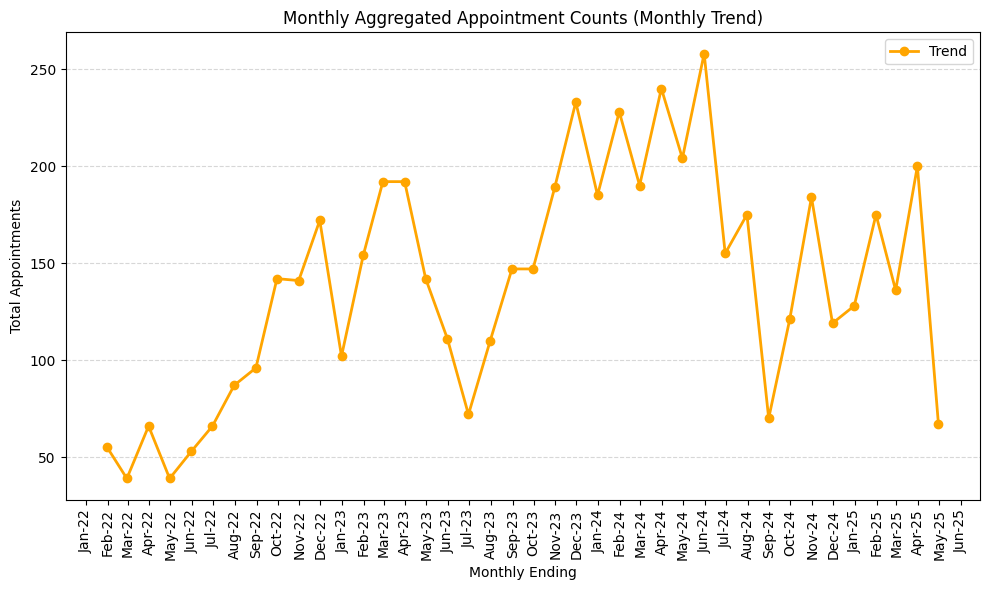

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Load your data.
#    If you’ve exported from Sheets to CSV:
# 1. Load your data
df = pd.read_excel(
    '/content/drive/My Drive/GI_Behavior_Health/Parameters/BH Data CPT Code Retrieval.xlsx')
#    Or, if you still have it as an Excel file:
# df = pd.read_excel("appointments.xlsx", sheet_name="Report 3")

# 2) Identify the month‐columns (everything after “CPT Code”)
month_cols = df.columns.tolist()[2:]   # adjust the 2 if your first data column is elsewhere

# 3) Sum each month
monthly_totals = df[month_cols].sum()

# 4) (Optional) put into a tidy DataFrame
totals_df = monthly_totals.reset_index()
totals_df.columns = ["Month", "Total Appointments"]

#print(totals_df)

# assume totals_df looks like:
#        Month  Total Appointments
# 0   Jan-22                123
# 1   Feb-22                154
# ... etc.

# 1) parse Month into a true datetime and set as index
totals_df['Month'] = pd.to_datetime(totals_df['Month'], format='%b-%y')
totals_df = totals_df.set_index('Month')

# 2) resample into 3-month bins (quarters) and sum
#    You can use 'Q' if your months align to calendar quarters (Mar/Jun/Sep/Dec).
#    Or '3M' to group every 3 months from the start.
quarterly = totals_df['Total Appointments'].resample('1M').sum()

# 3) plot the quarterly totals
fig, ax = plt.subplots(figsize=(10,6))

# # Bar chart of quarterly totals
# ax.bar(
#     quarterly.index,
#     quarterly.values,
#     width=30,           # adjust width (in days) so bars don’t overlap
#     alpha=0.6,
#     label='Quarterly Total'
# )

# Line chart overlaid for trend
ax.plot(
    quarterly.index,
    quarterly.values,
    marker='o',
    color='orange',
    linewidth=2,
    label='Trend'
)

# Labels, title, legend, and grid
ax.set_title('Monthly Aggregated Appointment Counts (Monthly Trend)')
ax.set_xlabel('Monthly Ending')
ax.set_ylabel('Total Appointments')
# ─── NEW: force month-by-month ticks ─────────────────────────────────────────
# 1) put a major tick on every month
ax.xaxis.set_major_locator(mdates.MonthLocator())
# 2) format each tick as abbreviated month-year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
# 3) rotate labels vertically
plt.setp(ax.get_xticklabels(), rotation=90, ha='center')
# ─────────────────────────────────────────────────────────────────────────────

ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()



## Analysis of Monthly Counts over Individual/Group Code

<ipython-input-29-da3b46ba66a4>:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  quarterly_by_type = monthly_by_type.resample('1M').sum()


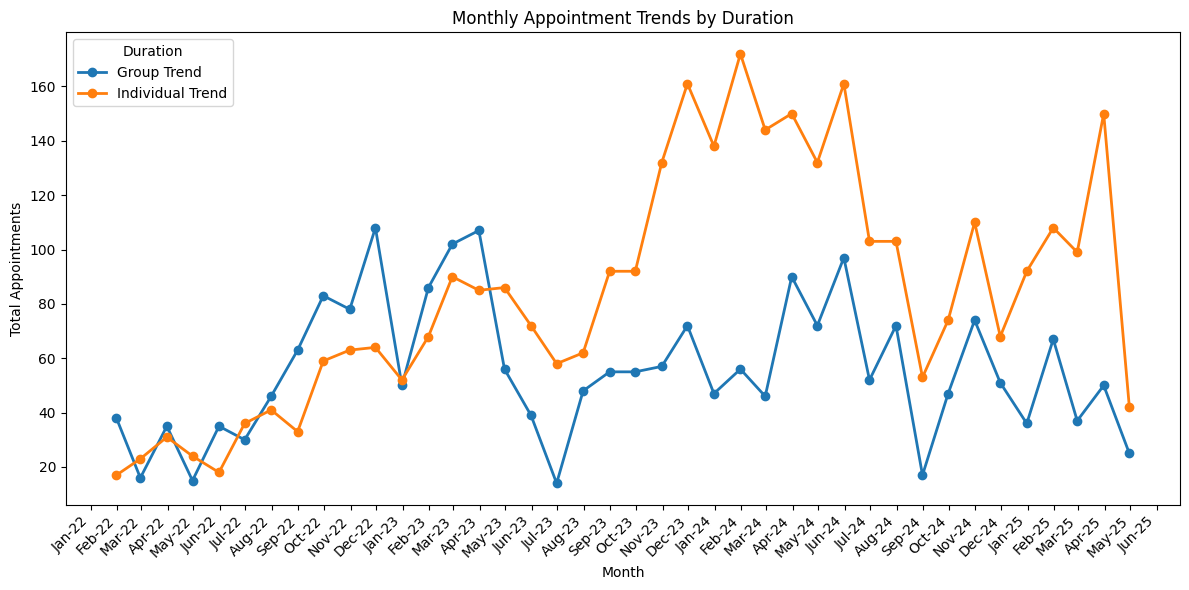

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load your appointment‐counts data
#    Replace with your actual path or filename
df = pd.read_excel('/content/drive/My Drive/GI_Behavior_Health/Parameters/BH Data CPT Code Retrieval.xlsx')

# 2) Identify the month columns (everything after “CPT Code”)
month_cols = df.columns.tolist()[2:]   # adjust “2” if your first data col is elsewhere

# 3) Unpivot into long form
df_long = df.melt(
    id_vars=['CPT Code'],
    value_vars=month_cols,
    var_name='Month',
    value_name='Count'
)
# parse Month into a datetime index
df_long['Month'] = pd.to_datetime(df_long['Month'], format='%b-%y')

# 4) Load your CPT→type mapping
#    mapping file must have columns: 'CPT Code' and 'CPT Description'
mapping = pd.read_excel('/content/drive/My Drive/GI_Behavior_Health/Parameters/Code Frequency.xlsx')
# keep only those two types
mapping = mapping[mapping['CPT Description'].isin(['group','individual'])]

# 5) merge counts with descriptions
merged = df_long.merge(mapping, on='CPT Code', how='inner')
merged['Count'] = merged['Count'].fillna(0).astype(int)

# 6) build a monthly pivot: rows=Month, cols=type, vals=sum(Count)
monthly_by_type = (
    merged
    .groupby(['Month','CPT Description'])['Count']
    .sum()
    .unstack(fill_value=0)
)

# 7) aggregate into 3‐month bins (quarterly sums)
quarterly_by_type = monthly_by_type.resample('1M').sum()

width = 60 # days

colors = ['tab:blue', 'tab:orange']
fig, ax = plt.subplots(figsize=(12, 6))
for (ctype,color) in zip(['group', 'individual'],colors):
    #fig, ax = plt.subplots(figsize=(10, 6))

    # # bar chart
    # ax.bar(
    #     quarterly_by_type.index - pd.offsets.Day(width/2) if ctype=='group' else quarterly_by_type.index + pd.offsets.Day(width/2),
    #     quarterly_by_type[ctype],
    #     width=width,
    #     alpha=0.6,
    #     label=ctype.capitalize()
    # )
    # line chart
    ax.plot(
        quarterly_by_type.index,
        quarterly_by_type[ctype],
        marker='o',
        color = color,
        linewidth=2,
        label=f'{ctype.capitalize()} Trend'
    )

ax.set_title('Monthly Appointment Trends by Duration')
ax.set_xlabel('Month')
ax.set_ylabel('Total Appointments')
ax.legend(title='Duration', loc='upper left')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()



## Analysis of Monthly Counts over Different Durations

<ipython-input-4-0b786ebd91a0>:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_by_time = monthly_by_time.resample('1M').sum()


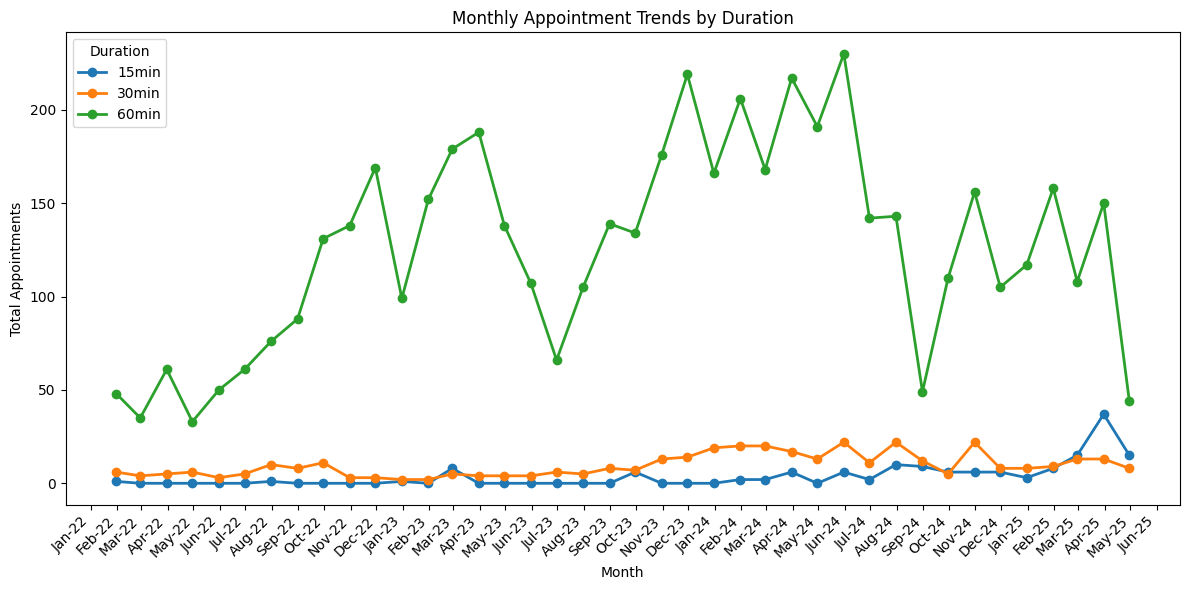

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Load your data
df = pd.read_excel('/content/drive/My Drive/GI_Behavior_Health/Parameters/BH Data CPT Code Retrieval.xlsx')

# 2) Identify month columns
month_cols = df.columns.tolist()[2:]

# 3) Unpivot into long form
df_long = df.melt(
    id_vars=['CPT Code'],
    value_vars=month_cols,
    var_name='Month',
    value_name='Count'
)
df_long['Month'] = pd.to_datetime(df_long['Month'], format='%b-%y')

# 4) Load mapping with 'Time'
mapping = pd.read_excel('/content/drive/My Drive/GI_Behavior_Health/Parameters/Code Frequency.xlsx')

# 5) Merge in durations
merged = df_long.merge(mapping[['CPT Code', 'Time']], on='CPT Code', how='inner')
merged['Count'] = merged['Count'].fillna(0).astype(int)

# 6) Pivot by Month x Time
monthly_by_time = (
    merged
    .groupby(['Month', 'Time'])['Count']
    .sum()
    .unstack('Time', fill_value=0)
)

# 7) Ensure every month appears
monthly_by_time = monthly_by_time.resample('1M').sum()

# 8) Single plot with 3 lines
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['tab:blue', 'tab:orange', 'tab:green']
for (duration, color) in zip(monthly_by_time.columns, colors):
    ax.plot(
        monthly_by_time.index,
        monthly_by_time[duration],
        marker='o',
        linewidth=2,
        color=color,
        label=f'{int(duration)}min'
    )

ax.set_title('Monthly Appointment Trends by Duration')
ax.set_xlabel('Month')
ax.set_ylabel('Total Appointments')
ax.legend(title='Duration', loc='upper left')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## Analysis of Monthly Counts for Each Provider

Service Provider            DUARTE, BROOKE A  HACKER, KATRINA S  \
Month      CPT Description                                        
2022-02-28 group                           0                  0   
           individual                      0                  0   
2022-03-31 group                           0                  0   
           individual                      0                  0   
2022-04-30 group                           0                  0   

Service Provider            LEE, SAMANTHA K  SALWEN-DEREMER, JESSICA K  
Month      CPT Description                                              
2022-02-28 group                          0                         16  
           individual                     0                         23  
2022-03-31 group                          0                         35  
           individual                     0                         31  
2022-04-30 group                          0                         15  


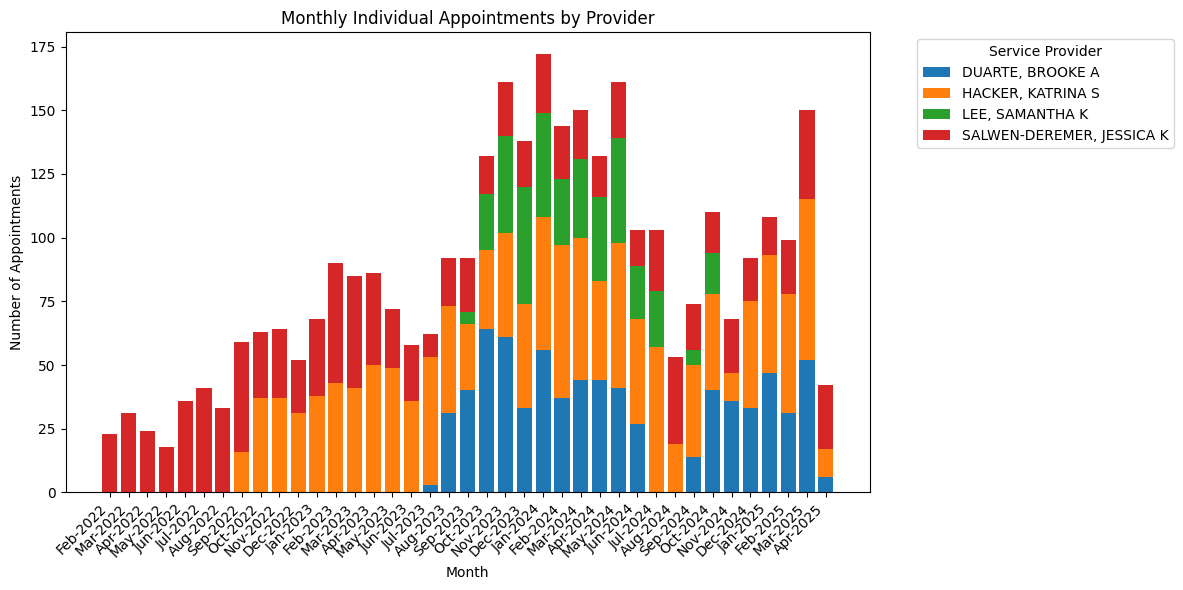

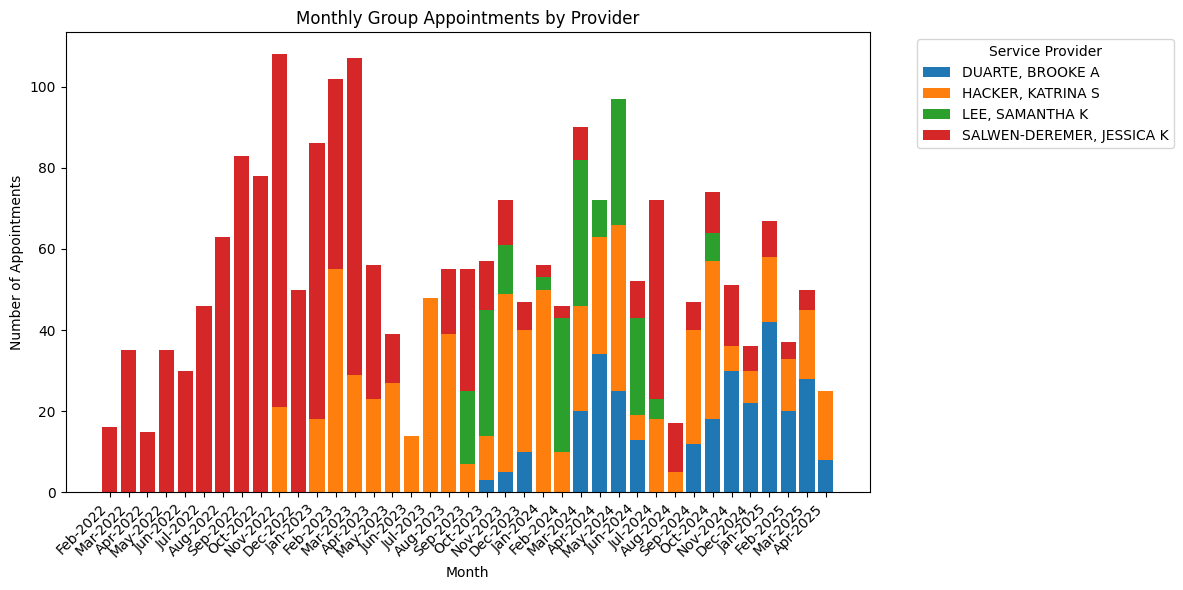

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Load your data
df = pd.read_excel(
    '/content/drive/My Drive/GI_Behavior_Health/Parameters/BH Data CPT Code Retrieval.xlsx'
)

# 2) Identify the month columns (everything after “Service Provider” and “CPT Code”)
month_cols = df.columns.tolist()[3:]

# 3) Unpivot into long form
df_long = df.melt(
    id_vars=['Service Provider', 'CPT Code'],
    value_vars=month_cols,
    var_name='Month',
    value_name='Count'
)
df_long['Month'] = pd.to_datetime(df_long['Month'], format='%b-%y')

# 4) Load your CPT→type mapping
mapping = pd.read_excel(
    '/content/drive/My Drive/GI_Behavior_Health/Parameters/Code Frequency.xlsx'
)
mapping = mapping[mapping['CPT Description'].isin(['group', 'individual'])]

# 5) Merge and clean
merged = df_long.merge(mapping, on='CPT Code', how='inner')
merged['Count'] = merged['Count'].fillna(0).astype(int)

# 6) Pivot to get monthly counts by provider and CPT type
monthly_by_provider = (
    merged
    .groupby(['Month', 'Service Provider', 'CPT Description'])['Count']
    .sum()
    .unstack('Service Provider')      # providers become columns
)

print(monthly_by_provider.head())

# 7) For each CPT type, plot a stacked monthly bar chart of providers
# For ‘individual’
df_individual = monthly_by_provider.xs('individual', level='CPT Description')
df_group      = monthly_by_provider.xs('group',      level='CPT Description')

for df, ctype in [(df_individual, 'Individual'), (df_group, 'Group')]:
    x = np.arange(len(df.index))      # 0,1,2,… for each Month
    bottom = np.zeros(len(x))

    fig, ax = plt.subplots(figsize=(12, 6))
    for provider in df.columns:
        ax.bar(
            x,
            df[provider].values,
            bottom=bottom,
            width=0.8,
            label=provider
        )
        bottom += df[provider].values

    # Titles & legend
    ax.set_title(f'Monthly {ctype} Appointments by Provider')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Appointments')
    ax.legend(title='Service Provider', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Use your Month index for tick labels
    ax.set_xticks(x)
    ax.set_xticklabels(
        df.index.strftime('%b-%Y'),
        rotation=45,
        ha='right'
    )

    plt.tight_layout()
    plt.show()g


## Analysis of Monthly Counts for Each Duration

<ipython-input-5-baeeefd8fd40>:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range(start=merged['Month'].min(), end=merged['Month'].max(), freq='M')


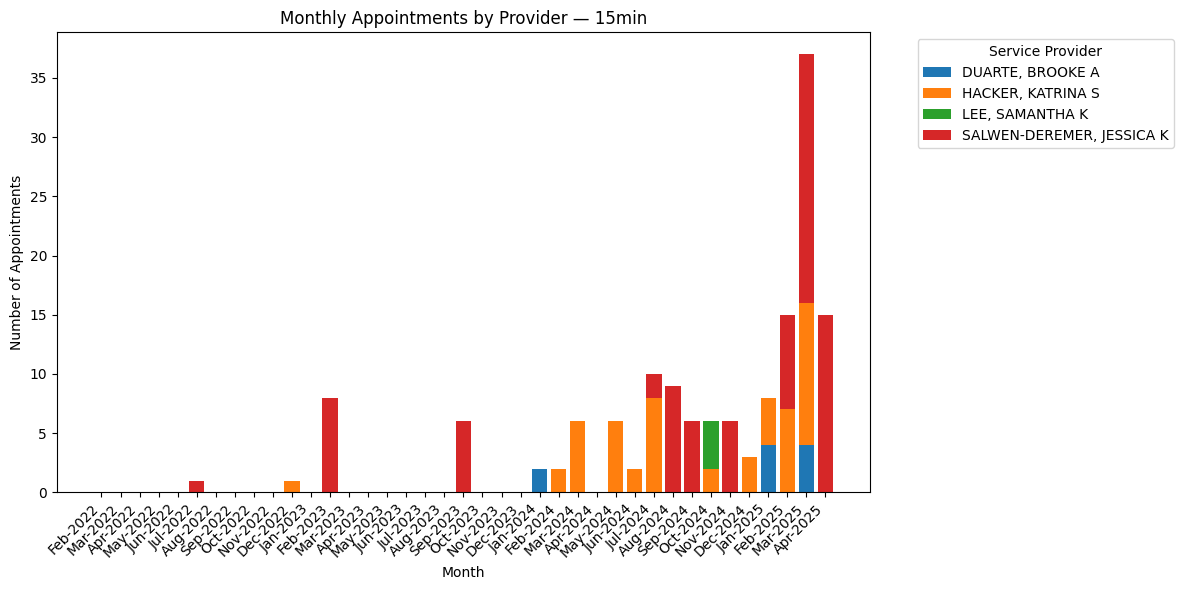

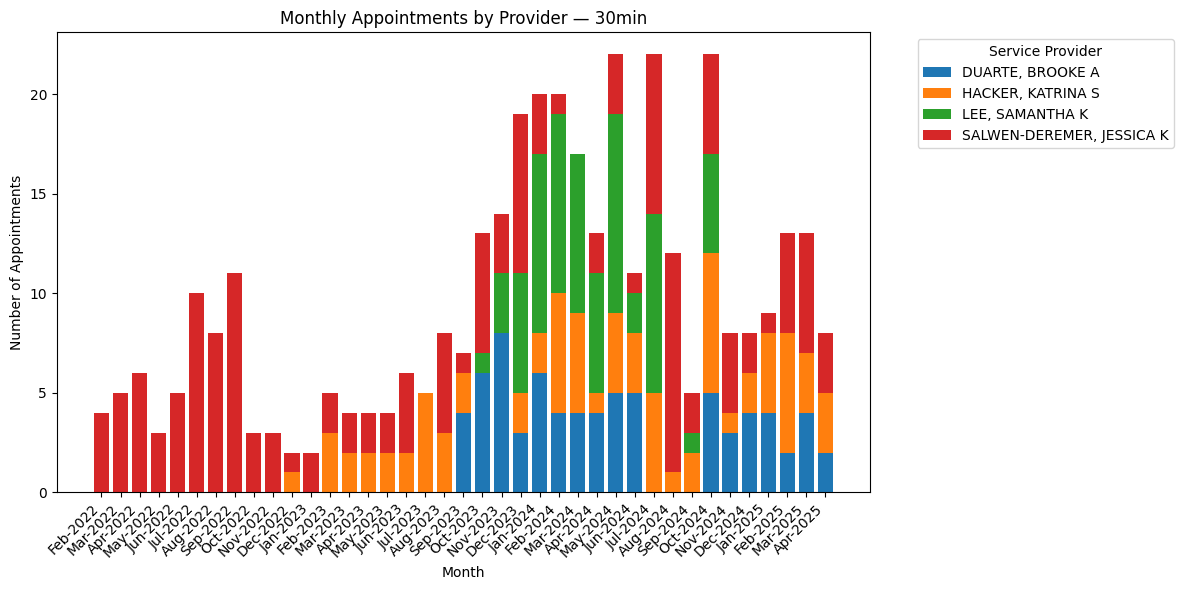

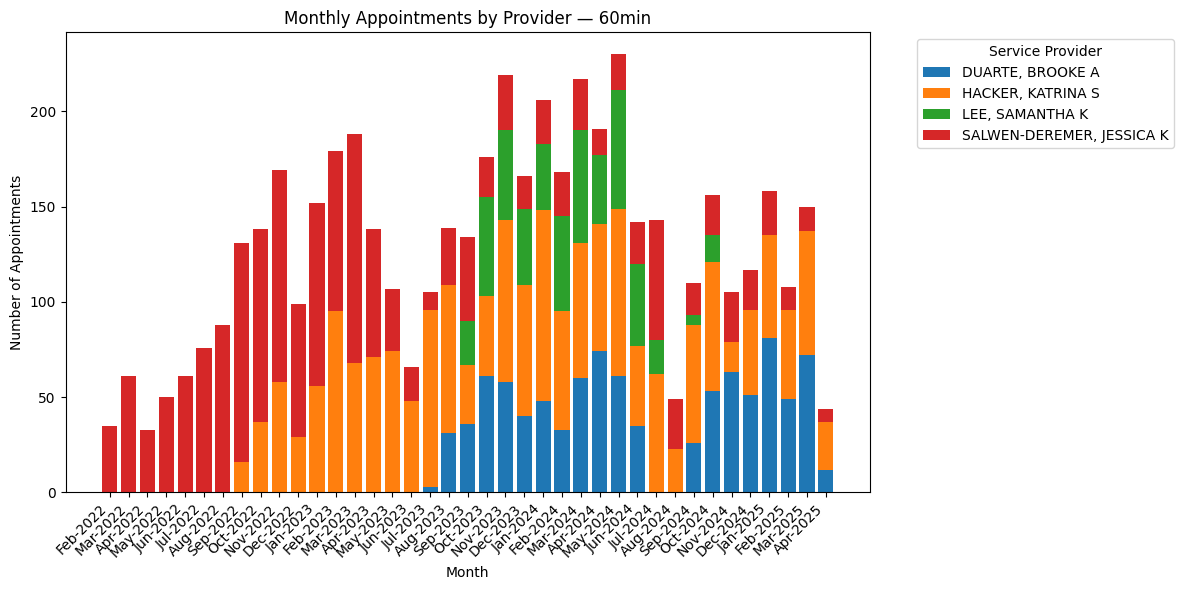

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load your appointment‐counts data
df = pd.read_excel('/content/drive/My Drive/GI_Behavior_Health/Parameters/BH Data CPT Code Retrieval.xlsx')

# 2) Identify the month columns (everything after “Service Provider” and “CPT Code”)
month_cols = df.columns.tolist()[3:]

# 3) Unpivot into long form
df_long = df.melt(
    id_vars=['Service Provider', 'CPT Code'],
    value_vars=month_cols,
    var_name='Month',
    value_name='Count'
)
df_long['Month'] = pd.to_datetime(df_long['Month'], format='%b-%y')

# 4) Load your CPT→mapping including 'Time' durations (15min, 30min, 60min)
mapping = pd.read_excel('/content/drive/My Drive/GI_Behavior_Health/Parameters/Code Frequency.xlsx')

# 5) Merge to bring in 'Time'
merged = df_long.merge(mapping[['CPT Code', 'Time']], on='CPT Code', how='inner')
merged['Count'] = merged['Count'].fillna(0).astype(int)

# 6) Pivot to get monthly counts by Time and Provider
pivot = (
    merged
    .groupby(['Time', 'Month', 'Service Provider'])['Count']
    .sum()
    .unstack('Service Provider', fill_value=0)
)

# 7) Create a complete sequence of months
all_months = pd.date_range(start=merged['Month'].min(), end=merged['Month'].max(), freq='M')

# 8) Generate a bar chart for each duration
for duration in pivot.index.get_level_values('Time').unique():
    df_dur = pivot.xs(duration, level='Time').reindex(all_months, fill_value=0)
    x = np.arange(len(all_months))
    bottom = np.zeros(len(x))

    fig, ax = plt.subplots(figsize=(12, 6))
    for provider in df_dur.columns:
        ax.bar(
            x,
            df_dur[provider].values,
            bottom=bottom,
            width=0.8,
            label=provider
        )
        bottom += df_dur[provider].values

    ax.set_title(f'Monthly Appointments by Provider — {int(duration)}min')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Appointments')
    ax.legend(title='Service Provider', bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_xticks(x)
    ax.set_xticklabels([d.strftime('%b-%Y') for d in all_months], rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


In [ ]:
df.index


DatetimeIndex(['2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31',
               '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
               '2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31',
               '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
               '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30',
               '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31',
               '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31',
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31', '2025-04-30'],
              dtype='datetime64[ns]', name='Month', freq=None)